This is the code for Approach 1 mentioned in the project report.
We finetunes GPT2-medium to play the game TicTacToe.
The MCTS part of the code is adopted from https://github.com/suragnair/alpha-zero-general
The checkpoint for the testing results showed in the paper is available upon request

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
import torch

In [3]:
tokenizer = AutoTokenizer.from_pretrained("gpt2-medium")
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained("gpt2-medium")

In [4]:
tokenizer.vocab_size

50257

In [5]:
# some testing
enc = tokenizer('''The game is played on a grid that's 3 squares by 3 squares. I am are X, your friend is O . Players take turns putting their marks in empty squares. The first player to get 3 of her marks in a row (up, down, across, or diagonally) is the winner. When all 9 squares are full, the game is over. If no player has 3 marks in a row, the game ends in a tie. We label the grid from 1 (top left) to 9 (bottom right). Only a single pawn can be on any position, so you can't play where there's already a pawn. If I play optimally, the next play should be at position numbered''', return_tensors='pt')

In [6]:
enc['input_ids']

tensor([[  464,   983,   318,  2826,   319,   257, 10706,   326,   338,   513,
         24438,   416,   513, 24438,    13,   314,   716,   389,  1395,    11,
           534,  1545,   318,   440,   764, 13094,  1011,  4962,  5137,   511,
          8849,   287,  6565, 24438,    13,   383,   717,  2137,   284,   651,
           513,   286,   607,  8849,   287,   257,  5752,   357,   929,    11,
           866,    11,  1973,    11,   393,  2566,  1840,   453,     8,   318,
           262,  8464,    13,  1649,   477,   860, 24438,   389,  1336,    11,
           262,   983,   318,   625,    13,  1002,   645,  2137,   468,   513,
          8849,   287,   257,  5752,    11,   262,   983,  5645,   287,   257,
          9839,    13,   775,  6167,   262, 10706,   422,   352,   357,  4852,
          1364,     8,   284,   860,   357, 22487,   826,   737,  5514,   257,
          2060, 29649,   460,   307,   319,   597,  2292,    11,   523,   345,
           460,   470,   711,   810,   612,   338,  

In [8]:
rules = "The game is played on a grid that's 3 squares by 3 squares. I am are X, your friend is O . Players take turns putting their marks in empty squares. The first player to get 3 of her marks in a row (up, down, across, or diagonally) is the winner. When all 9 squares are full, the game is over. If no player has 3 marks in a row, the game ends in a tie. We label the grid from 1 (top left) to 9 (bottom right), and 0 represent not moving this turn. Only a single pawn can be on any position, so you can't play where there's already a pawn. The current board is configured as "
rulespart2 = ". If I play optimally, the next play should be at position numbered"

def generate_prompt_policy(boardstring):
  if isinstance(boardstring, str):
    return rules + boardstring + rulespart2
  return [rules + item + rulespart2 for item in boardstring]

In [9]:
rules_val = "The game is played on a grid that's 3 squares by 3 squares. I am are X, your friend is O . Players take turns putting their marks in empty squares. The first player to get 3 of her marks in a row (up, down, across, or diagonally) is the winner. When all 9 squares are full, the game is over. If no player has 3 marks in a row, the game ends in a tie. We label the grid from 1 (top left) to 9 (bottom right). Only a single pawn can be on any position, so you can't play where there's already a pawn. The current board is configured as "
rulespart2_val = ". If I play optimally, and if I use a number from 1 to 9 representing the probability of me winning, with 1 being least likely to win and 9 being most likely to win, the number would be"

def generate_prompt_value(boardstring):
  if isinstance(boardstring, str):
    return rules_val + boardstring + rulespart2_val
  return [rules_val + item + rulespart2_val for item in boardstring]

In [14]:
import numpy as np

In [15]:
def get_policy(board_string):
  string = generate_prompt_policy(board_string)
  inputs = tokenizer(string, return_tensors="pt", padding=True)
  input = inputs.to(device)
  scores = []

  scores = model(**input).logits[:,-1,:]
  seq_vec = [352, 362, 513, 604, 642, 718, 767, 807, 860, 657]
  # print(np.shape(scores))
  probs = torch.softmax(scores, dim = -1)[:, seq_vec]

  return probs, probs.sum(-1)

In [16]:
def get_value(board_string):
  string = generate_prompt_value(board_string)
  inputs = tokenizer(string, return_tensors="pt", padding=True)
  input = inputs.to(device)
  scores = []

  scores = model(**input).logits[:,-1,:]
  seq_vec = [352, 362, 513, 604, 642, 718, 767, 807, 860]
  val_vec = [-0.99, -0.6, -0.3, -0.15, 0.001, 0.15, 0.3, 0.6, 0.99]
  probs = torch.softmax(scores, dim = -1)[:, seq_vec]
  val_vec = torch.tensor(val_vec, dtype=torch.float).to(device)

  return (probs*val_vec).sum(-1), probs.sum(-1)

In [18]:
import torch.optim as optim
import numpy as np
import torch.nn as nn

In [21]:
import torch.optim as optim
import tqdm
import time
from torch.autograd import Variable
import logging
import numpy as np

In [24]:
loss_hist = []

In [26]:
from tictactoe.TicTacToeGame import TicTacToeGame as Game

In [27]:
class AverageMeter(object):
    """From https://github.com/pytorch/examples/blob/master/imagenet/main.py"""

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def __repr__(self):
        return f'{self.avg:.2e}'

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class dotdict(dict):
    def __getattr__(self, name):
        return self[name]

In [28]:
args = dotdict({
    'lr': 0.001,
    'dropout': 0.3,
    'epochs': 10,
    'batch_size': 1,
    'cuda': torch.cuda.is_available(),
    'num_channels': 512,
})

In [29]:
import torch.nn.functional as F


In [30]:
criterion = nn.CrossEntropyLoss()
mse = nn.MSELoss()

In [31]:
def loss_pi(targets, outputs):
        # print(outputs, targets, "pi")
        # targets += 3
        return criterion(outputs, targets)

def loss_v(targets, outputs):
    # print(targets, outputs, "aaa")
    # print(targets, outputs, "v")

    return mse(outputs.unsqueeze(0),targets.unsqueeze(0))

In [32]:
trainexs = []

In [33]:
def print_board(board_list):
  if board_list.ndim == 3:
    lst = []
    for board in board_list:
          board = board.reshape(3,3)
          n = board.shape[0]
          letters = ['A', 'B', 'C']
          string = '   '
          for y in range(n):
              string += f'{y+1} '
          string += '\n'

          for x in range(n):
              string += f'  {letters[x]} '
              string += '|'
              for y in range(n):
                  string += 'X' * int(board[x, y] == -1)
                  string += 'O' * int(board[x, y] == 1)
                  string += ' ' * int(board[x, y] == 0)
                  string += '|'
              string += '''\n'''
          lst.append(string)
  else:
        board = board_list.reshape(3,3)
        n = board.shape[0]
        letters = ['A', 'B', 'C']
        string = '   '
        for y in range(n):
            string += f'{y+1} '
        string += '\n'

        for x in range(n):
            string += f'  {letters[x]} '
            string += '|'
            for y in range(n):
                string += 'X' * int(board[x, y] == -1)
                string += 'O' * int(board[x, y] == 1)
                string += ' ' * int(board[x, y] == 0)
                string += '|'
            string += '''\n'''
        lst = string
  return lst

In [34]:
def is_nan(x):
    return x != x

In [35]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001,betas = (0.9, 0.999), weight_decay = 0)

In [36]:
def train(examples):
  optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001,betas = (0.9, 0.999), weight_decay = 0)
  optimizer.zero_grad()
  # print(examples,"examples")
  for epoch in range(args.epochs):
      print('EPOCH ::: ' + str(epoch + 1))
      # Actual Training Part


      pi_losses = AverageMeter()
      v_losses = AverageMeter()

      batch_count = int(len(examples) / args.batch_size)

      t = tqdm(range(batch_count), desc='Training Net')
      for (i, _) in enumerate(t):
          
          sample_ids = np.random.randint(len(examples), size=args.batch_size)
          boards, pis, vs = list(zip(*[examples[i] for i in sample_ids]))


          boards = torch.FloatTensor(np.array(boards).astype(np.float64))
          target_pis = torch.FloatTensor(np.array(pis))
          target_vs = torch.FloatTensor(np.array(vs).astype(np.float64))
          target_vs.requires_grad = True
          target_pis.requires_grad = True

          # predict
          if args.cuda:
              boards, target_pis, target_vs = boards.contiguous().cuda(), target_pis.contiguous().cuda(), target_vs.contiguous().cuda()

          # TODO: Convert board to string
          board_string = print_board(boards)

          # compute output
          out_v, vvalid = get_value(board_string)
          out_pi, pvalid = get_policy(board_string)
          l_pi = loss_pi(target_pis, out_pi)
          l_v = loss_v(target_vs, out_v)
          total_loss = (l_pi + l_v)
          loss_hist.append((l_pi + l_v).item())
          # total_loss = Variable(total_loss,requires_grad=True)
          # if i % 50 == 0:
          #   print("Target_pi: ", target_pis, "predicted_pi", out_pi, "targetv", target_vs, "predicted_v", out_v, "policy_loss", l_pi, "value_loss", l_v)
          if is_nan(l_pi) or is_nan(l_v):
            "NANS DETECTED !!"
            if is_nan(l_pi):
              l_pi = torch.tensor(0.0, requires_grad=True)
              pi_losses.update(0, boards.size(0))
            if is_nan(l_v):
              l_v = torch.tensor(0.0, requires_grad=True)
            # record loss
            pi_losses.update(l_pi.item(), boards.size(0))
            v_losses.update(l_v.item(), boards.size(0))
            t.set_postfix(Loss_pi=pi_losses, Loss_v=v_losses)
            optimizer.zero_grad()

          else:
            

            # record loss
            pi_losses.update(l_pi.item(), boards.size(0))
            v_losses.update(l_v.item(), boards.size(0))
            t.set_postfix(Loss_pi=pi_losses, Loss_v=v_losses)

            total_loss.backward()

            if (i % 1 == 0) or (i + 1 == len(t)):
              optimizer.step()
              optimizer.zero_grad()

In [37]:
@torch.no_grad()
def predict(board):
  # timing
  start = time.time()
  #  preparing input
  board = torch.FloatTensor(board.astype(np.float64)).to(device)
  boardstr = print_board(board)
  v, _ = get_value(boardstr)
  pi, _ = get_policy(boardstr)
  alpha = 1.1
  alpha = 1.1
  sample_size = 10

  # Generate sample from Dirichlet distribution
  sample = np.random.dirichlet([alpha] * sample_size)
  
  return (pi[0].data.cpu().numpy()*0.75+sample*0.25), v[0].data.cpu().numpy()

In [38]:
import logging
import math

import numpy as np

EPS = 5e-7

log = logging.getLogger(__name__)


class MCTS():
    """
    This class handles the MCTS tree.
    """

    def __init__(self, game, args):
        self.game = game
        self.args = args
        self.Qsa = {}  # stores Q values for s,a (as defined in the paper)
        self.Nsa = {}  # stores #times edge s,a was visited
        self.Ns = {}  # stores #times board s was visited
        self.Ps = {}  # stores initial policy (returned by neural net)

        self.Es = {}  # stores game.getGameEnded ended for board s
        self.Vs = {}  # stores game.getValidMoves for board s

    def getActionProb(self, canonicalBoard, temp=1):
        """
        This function performs numMCTSSims simulations of MCTS starting from
        canonicalBoard.

        Returns:
            probs: a policy vector where the probability of the ith action is
                   proportional to Nsa[(s,a)]**(1./temp)
        """
        for i in range(self.args.numMCTSSims):
            self.search(canonicalBoard)

        s = self.game.stringRepresentation(canonicalBoard)
        counts = [self.Nsa[(s, a)] if (s, a) in self.Nsa else 0 for a in range(self.game.getActionSize())]

        if temp == 0:
            bestAs = np.array(np.argwhere(counts == np.max(counts))).flatten()
            bestA = np.random.choice(bestAs)
            probs = [0] * len(counts)
            probs[bestA] = 1
            return probs

        counts = [x ** (1. / temp) for x in counts]
        counts_sum = float(sum(counts))
        probs = [x / counts_sum for x in counts]
        return probs

    def search(self, canonicalBoard):
        """
        This function performs one iteration of MCTS. It is recursively called
        till a leaf node is found. The action chosen at each node is one that
        has the maximum upper confidence bound as in the paper.

        Once a leaf node is found, the neural network is called to return an
        initial policy P and a value v for the state. This value is propagated
        up the search path. In case the leaf node is a terminal state, the
        outcome is propagated up the search path. The values of Ns, Nsa, Qsa are
        updated.

        NOTE: the return values are the negative of the value of the current
        state. This is done since v is in [-1,1] and if v is the value of a
        state for the current player, then its value is -v for the other player.

        Returns:
            v: the negative of the value of the current canonicalBoard
        """

        s = self.game.stringRepresentation(canonicalBoard)

        if s not in self.Es:
            self.Es[s] = self.game.getGameEnded(canonicalBoard, 1)
        if self.Es[s] != 0:
            # terminal node
            return -self.Es[s]

        if s not in self.Ps:
            # leaf node
            self.Ps[s], v = predict(canonicalBoard)
            valids = self.game.getValidMoves(canonicalBoard, 1)
            # print(valids,len(valids),canonicalBoard)
            self.Ps[s] = self.Ps[s] * valids  # masking invalid moves
            sum_Ps_s = np.sum(self.Ps[s])
            if sum_Ps_s > 0:
                self.Ps[s] /= sum_Ps_s  # renormalize
            else:
                # if all valid moves were masked make all valid moves equally probable

                # NB! All valid moves may be masked if either your NNet architecture is insufficient or you've get overfitting or something else.
                # If you have got dozens or hundreds of these messages you should pay attention to your NNet and/or training process.   
                log.error("All valid moves were masked, doing a workaround.")
                self.Ps[s] = self.Ps[s] + valids
                self.Ps[s] /= np.sum(self.Ps[s])

            self.Vs[s] = valids
            self.Ns[s] = 0
            return -v

        valids = self.Vs[s]
        cur_best = -float('inf')
        best_act = -1

        # pick the action with the highest upper confidence bound
        for a in range(self.game.getActionSize()):
            if valids[a]:
                if (s, a) in self.Qsa:
                    u = self.Qsa[(s, a)] + self.args.cpuct * self.Ps[s][a] * math.sqrt(self.Ns[s]) / (
                            1 + self.Nsa[(s, a)])
                else:
                    u = self.args.cpuct * self.Ps[s][a] * math.sqrt(self.Ns[s] + EPS)  # Q = 0 ?

                if u > cur_best:
                    cur_best = u
                    best_act = a

        a = best_act
        next_s, next_player = self.game.getNextState(canonicalBoard, 1, a)
        next_s = self.game.getCanonicalForm(next_s, next_player)

        v = self.search(next_s)

        if (s, a) in self.Qsa:
            self.Qsa[(s, a)] = (self.Nsa[(s, a)] * self.Qsa[(s, a)] + v) / (self.Nsa[(s, a)] + 1)
            self.Nsa[(s, a)] += 1

        else:
            self.Qsa[(s, a)] = v
            self.Nsa[(s, a)] = 1

        self.Ns[s] += 1
        return -v

In [39]:
import logging
import os
import sys
from collections import deque
from pickle import Pickler, Unpickler
from random import shuffle

import numpy as np
from tqdm import tqdm


log = logging.getLogger(__name__)


class Coach():
    """
    This class executes the self-play + learning. It uses the functions defined
    in Game and NeuralNet. args are specified in main.py.
    """

    def __init__(self, game, args):
        self.game = game
        # self.nnet = nnet
        # self.pnet = self.nnet.__class__(self.game)  # the competitor network
        self.args = args
        self.mcts = MCTS(self.game, self.args)
        self.trainExamplesHistory = []  # history of examples from args.numItersForTrainExamplesHistory latest iterations
        self.skipFirstSelfPlay = False  # can be overriden in loadTrainExamples()

    def executeEpisode(self):
        """
        This function executes one episode of self-play, starting with player 1.
        As the game is played, each turn is added as a training example to
        trainExamples. The game is played till the game ends. After the game
        ends, the outcome of the game is used to assign values to each example
        in trainExamples.

        It uses a temp=1 if episodeStep < tempThreshold, and thereafter
        uses temp=0.

        Returns:
            trainExamples: a list of examples of the form (canonicalBoard, currPlayer, pi,v)
                           pi is the MCTS informed policy vector, v is +1 if
                           the player eventually won the game, else -1.
        """
        trainExamples = []
        board = self.game.getInitBoard()
        self.curPlayer = 1
        episodeStep = 0

        while True:
            episodeStep += 1
            canonicalBoard = self.game.getCanonicalForm(board, self.curPlayer)
            temp = int(episodeStep < self.args.tempThreshold)

            pi = self.mcts.getActionProb(canonicalBoard, temp=temp)
            sym = self.game.getSymmetries(canonicalBoard, pi)
            for b, p in sym:
                trainExamples.append([b, self.curPlayer, p, None])

            action = np.random.choice(len(pi), p=pi)
            board, self.curPlayer = self.game.getNextState(board, self.curPlayer, action)

            r = self.game.getGameEnded(board, self.curPlayer)
            if r != 0:
                return [(x[0], x[2], r * ((-1) ** (x[1] != self.curPlayer))) for x in trainExamples]

    def learn(self):
        """
        Performs numIters iterations with numEps episodes of self-play in each
        iteration. After every iteration, it retrains neural network with
        examples in trainExamples (which has a maximum length of maxlenofQueue).
        It then pits the new neural network against the old one and accepts it
        only if it wins >= updateThreshold fraction of games.
        """

        for i in range(1, self.args.numIters + 1):
            # bookkeeping
            log.info(f'Starting Iter #{i} ...')
            # examples of the iteration
            if not self.skipFirstSelfPlay or i > 1:
                iterationTrainExamples = deque([], maxlen=self.args.maxlenOfQueue)

                for _ in tqdm(range(self.args.numEps), desc="Self Play"):
                    self.mcts = MCTS(self.game, self.args)  # reset search tree
                    iterationTrainExamples += self.executeEpisode()

                # save the iteration examples to the history 
                self.trainExamplesHistory.append(iterationTrainExamples)

            if len(self.trainExamplesHistory) > self.args.numItersForTrainExamplesHistory:
                log.warning(
                    f"Removing the oldest entry in trainExamples. len(trainExamplesHistory) = {len(self.trainExamplesHistory)}")
                self.trainExamplesHistory.pop(0)
            # backup history to a file
            # NB! the examples were collected using the model from the previous iteration, so (i-1)  
            self.saveTrainExamples(i - 1)

            # shuffle examples before training
            trainExamples = []
            for e in self.trainExamplesHistory:
                trainExamples.extend(e)
            shuffle(trainExamples)

            # # training new network, keeping a copy of the old one
            # self.nnet.save_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
            # self.pnet.load_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')


            train(trainExamples)
            torch.save(model.state_dict(), 'my_model.pt')



    def getCheckpointFile(self, iteration):
        return 'checkpoint_' + str(iteration) + '.pth.tar'

    def saveTrainExamples(self, iteration):
        folder = self.args.checkpoint
        if not os.path.exists(folder):
            os.makedirs(folder)
        filename = os.path.join(folder, self.getCheckpointFile(iteration) + ".examples")
        with open(filename, "wb+") as f:
            Pickler(f).dump(self.trainExamplesHistory)
        f.closed

    def loadTrainExamples(self):
        modelFile = os.path.join(self.args.load_folder_file[0], self.args.load_folder_file[1])
        examplesFile = modelFile + ".examples"
        if not os.path.isfile(examplesFile):
            log.warning(f'File "{examplesFile}" with trainExamples not found!')
            r = input("Continue? [y|n]")
            if r != "y":
                sys.exit()
        else:
            log.info("File with trainExamples found. Loading it...")
            with open(examplesFile, "rb") as f:
                self.trainExamplesHistory = Unpickler(f).load()
            log.info('Loading done!')

            # examples based on the model were already collected (loaded)
            self.skipFirstSelfPlay = True

In [40]:
# Run training loop
log = logging.getLogger(__name__)


args = dotdict({
    'numIters': 1000,
    'numEps': 15,              # Number of complete self-play games to simulate during a new iteration.
    'tempThreshold': 15,        #
    'updateThreshold': 0.6,     # During arena playoff, new neural net will be accepted if threshold or more of games are won.
    'maxlenOfQueue': 3500,    # Number of game examples to train the neural networks.
    'numMCTSSims': 25,          # Number of games moves for MCTS to simulate.
    'arenaCompare': 40,         # Number of games to play during arena play to determine if new net will be accepted.
    'cpuct': 1,
    'epochs': 1,
     'lr': 0.001,
    'dropout': 0.3,
    'batch_size': 3,
    'cuda': torch.cuda.is_available(),
    'num_channels': 512,

    'checkpoint': './temp/',
    'load_model': False,
    'load_folder_file': ('/dev/models/8x100x50','best.pth.tar'),
    'numItersForTrainExamplesHistory': 20,

})


def main():
    log.info('Loading %s...', Game.__name__)
    g = Game(3)

    # log.info('Loading %s...', nn.__name__)


    log.info('Loading the Coach...')
    c = Coach(g, args)

    if args.load_model:
        log.info("Loading 'trainExamples' from file...")
        c.loadTrainExamples()

    log.info('Starting the learning process 🎉')
    c.learn()


In [41]:
log.info('Loading %s...', Game.__name__)
g = Game(3)
device = 'cuda'
model.to(device)

# log.info('Loading %s...', nn.__name__)


log.info('Loading the Coach...')
c = Coach(g, args)

if args.load_model:
    log.info("Loading 'trainExamples' from file...")
    c.loadTrainExamples()

log.info('Starting the learning process 🎉')
c.learn()

Self Play: 100%|██████████| 15/15 [01:05<00:00,  4.37s/it]


EPOCH ::: 1


Self Play: 100%|██████████| 15/15 [00:59<00:00,  3.99s/it]


EPOCH ::: 1


Self Play: 100%|██████████| 15/15 [00:57<00:00,  3.85s/it]


EPOCH ::: 1


Self Play: 100%|██████████| 15/15 [00:54<00:00,  3.60s/it]


EPOCH ::: 1


Self Play: 100%|██████████| 15/15 [00:42<00:00,  2.86s/it]


EPOCH ::: 1


Self Play: 100%|██████████| 15/15 [00:40<00:00,  2.68s/it]


EPOCH ::: 1


Self Play: 100%|██████████| 15/15 [00:49<00:00,  3.29s/it]


EPOCH ::: 1


Self Play: 100%|██████████| 15/15 [00:34<00:00,  2.29s/it]


EPOCH ::: 1


Self Play: 100%|██████████| 15/15 [00:44<00:00,  2.96s/it]


EPOCH ::: 1


Self Play: 100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


EPOCH ::: 1


Self Play: 100%|██████████| 15/15 [00:40<00:00,  2.68s/it]


EPOCH ::: 1


Self Play: 100%|██████████| 15/15 [00:42<00:00,  2.81s/it]


EPOCH ::: 1


Self Play: 100%|██████████| 15/15 [00:42<00:00,  2.83s/it]


EPOCH ::: 1


Self Play: 100%|██████████| 15/15 [00:41<00:00,  2.79s/it]


EPOCH ::: 1


Self Play: 100%|██████████| 15/15 [00:37<00:00,  2.50s/it]


EPOCH ::: 1


Self Play: 100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


EPOCH ::: 1


Self Play: 100%|██████████| 15/15 [00:32<00:00,  2.19s/it]


EPOCH ::: 1


Self Play: 100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


EPOCH ::: 1


Self Play: 100%|██████████| 15/15 [00:33<00:00,  2.21s/it]


EPOCH ::: 1


Self Play: 100%|██████████| 15/15 [00:32<00:00,  2.19s/it]


EPOCH ::: 1


Self Play: 100%|██████████| 15/15 [00:33<00:00,  2.26s/it]
Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 21


EPOCH ::: 1


Training Net:  19%|█▊        | 1142/6141 [06:31<28:33,  2.92it/s, Loss_pi=1.88e+00, Loss_v=2.81e-01]


KeyboardInterrupt: 

In [ ]:
import pickle
# !touch loss_hist.pkl
with open('loss_hist.pkl', 'wb') as f:
    pickle.dump(loss_hist, f)

In [ ]:
c.learn()

In [ ]:
torch.save(model.state_dict(), 'my_model.pt')

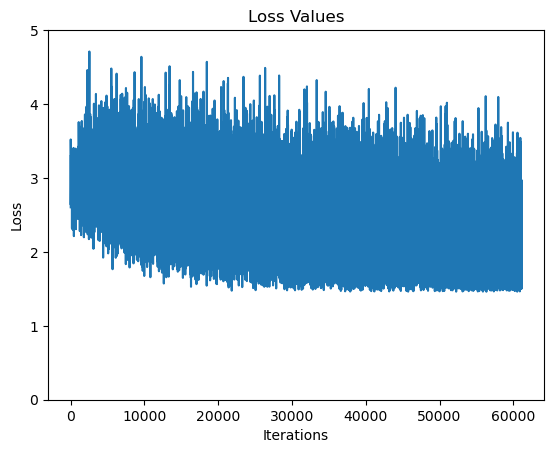

In [84]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

# Plot the loss values
ax.plot(loss_hist)

# Set the title and labels for the plot
ax.set_title('Loss Values')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_ylim([0, 5])

# Show the plot
plt.show()
fig.savefig('loss_values_gpt.pdf')

In [43]:
from itertools import product

# Generate all possible configurations
possible_configs = product([-1, 0, 1], repeat=9)

# Filter out the ones where the number of 1's is greater than the number of -1's
configs = []
for config in possible_configs:
    config_array = np.array(config).reshape(3, 3)
    if (((config_array == 1).sum() <= (config_array == -1).sum()) and  (abs((config_array == -1).sum() - (config_array == 1).sum()) <= 1)) and (config_array == 0).sum() >= 1:
        configs.append(config_array)

In [44]:
filter = []
for config in configs:
    config_array = np.array(config).reshape(3, 3)
    if (config_array == 1).sum() <= (config_array == -1).sum():
        row_check = any((config_array == row).all() for row in [-1, 0, 1])
        col_check = any((config_array == col).all(axis=0).all() for col in [-1, 0, 1])
        diag_check = any((config_array == diag).all() for diag in [[-1, 0, 1], [1, 0, -1]])

        if not (row_check or col_check or diag_check):
            filter.append(config_array)

In [45]:
@torch.no_grad()
def test_for_valids(arr):
    string = print_board(np.array(arr))
    emb, _ = get_policy(string)
    actions = torch.argmax((emb), dim=-1)
    bat1 = np.array(arr).reshape((20,9))
    inds = actions
    bat = bat1[range(20), inds.detach().cpu().numpy()]
    return sum(abs(bat))

In [46]:
# testing for 5000 random valid permutations of the board - how many proposed actions are valid?
ctr = 0
for i in tqdm(range(250)):
    ctr += test_for_valids(filter[i*20: (i+1)*20])

100%|██████████| 250/250 [01:00<00:00,  4.16it/s]


In [48]:
ctr

92

In [ ]:
# testing performance

In [85]:
import logging

from tqdm import tqdm

log = logging.getLogger(__name__)


class Arena():
    """
    An Arena class where any 2 agents can be pit against each other.
    """

    def __init__(self, player1, player2, game, display=None):
        """
        Input:
            player 1,2: two functions that takes board as input, return action
            game: Game object
            display: a function that takes board as input and prints it (e.g.
                     display in othello/OthelloGame). Is necessary for verbose
                     mode.

        see othello/OthelloPlayers.py for an example. See pit.py for pitting
        human players/other baselines with each other.
        """
        self.player1 = player1
        self.player2 = player2
        self.game = game
        self.display = display

    def playGame(self, verbose=False):
        """
        Executes one episode of a game.

        Returns:
            either
                winner: player who won the game (1 if player1, -1 if player2)
            or
                draw result returned from the game that is neither 1, -1, nor 0.
        """
        players = [self.player2, None, self.player1]
        curPlayer = 1
        board = self.game.getInitBoard()
        it = 0
        while self.game.getGameEnded(board, curPlayer) == 0:
            it += 1
            if verbose:
                assert self.display
                print("Turn ", str(it), "Player ", str(curPlayer))
                self.display(board)
            action = players[curPlayer + 1](self.game.getCanonicalForm(board, curPlayer))

            valids = self.game.getValidMoves(self.game.getCanonicalForm(board, curPlayer), 1)

            if valids[action] == 0:
                log.error(f'Action {action} is not valid!')
                log.debug(f'valids = {valids}')
                assert valids[action] > 0
            board, curPlayer = self.game.getNextState(board, curPlayer, action)
        if verbose:
            assert self.display
            print("Game over: Turn ", str(it), "Result ", str(self.game.getGameEnded(board, 1)))
            self.display(board)
        return curPlayer * self.game.getGameEnded(board, curPlayer)

    def playGames(self, num, verbose=False):
        """
        Plays num games in which player1 starts num/2 games and player2 starts
        num/2 games.

        Returns:
            oneWon: games won by player1
            twoWon: games won by player2
            draws:  games won by nobody
        """

        num = int(num / 2)
        oneWon = 0
        twoWon = 0
        draws = 0
        for _ in tqdm(range(num), desc="Arena.playGames (1)"):
            gameResult = self.playGame(verbose=verbose)
            if gameResult == 1:
                oneWon += 1
            elif gameResult == -1:
                twoWon += 1
            else:
                draws += 1
        print(oneWon, twoWon, draws)

        self.player1, self.player2 = self.player2, self.player1

        for _ in tqdm(range(num), desc="Arena.playGames (2)"):
            gameResult = self.playGame(verbose=verbose)
            if gameResult == -1:
                oneWon += 1
            elif gameResult == 1:
                twoWon += 1
            else:
                draws += 1

        return oneWon, twoWon, draws

In [86]:
class RandomPlayer():
    def __init__(self, game):
        self.game = game

    def play(self, board):
        a = np.random.randint(self.game.getActionSize())
        valids = self.game.getValidMoves(board, 1)
        while valids[a]!=1:
            a = np.random.randint(self.game.getActionSize())
        return a

In [87]:
rp = RandomPlayer(g).play

In [88]:
class Netplayer():
    def __init__(self, game):
        self.game = game
        self.invalid = 0
    def play(self, board):
        with torch.no_grad():
            boardtsr = torch.FloatTensor(board.astype(np.float64)).to(device)
            string = print_board(boardtsr)
            emb, _ = get_policy(string)
            _, actions = torch.topk(emb, 9, dim = -1)
            actions = actions.detach().cpu()[0]
            valids = self.game.getValidMoves(board, 1)
            ctr = 0
            # print(actions)
            while valids[actions[ctr]] == 0:
                self.invalid += 1
                ctr += 1
            return actions[ctr]
    def query(self):
        return self.invalid
                

In [89]:
net = Netplayer(g)

In [90]:
arena = Arena(net.play, rp, g)

In [91]:
# Pitting trained network against a random player
arena.playGames(2000)

Arena.playGames (1): 100%|██████████| 1000/1000 [01:04<00:00, 15.39it/s]


910 8 82


Arena.playGames (2): 100%|██████████| 1000/1000 [01:08<00:00, 14.53it/s]


(1541, 60, 399)

In [56]:
# Total number of invalid actions made in the 2000 games simulated
net.query()

17

In [79]:
# Checking performance on ad-hoc board configurations
boards_test = np.array([np.array([[1, 0, 1],[-1,0,-1],[0,0,0]]), np.array([[1,0,1],[0,-1,0],[-1,0,0]]), np.array([[-1, -1,1],[-1,0,0],[1,0,1]]), np.array([[-1,-1,0],[0,0,1],[1,0,0]]),np.array([[1,-1,0],[1,0,1],[0,0,-1]]),np.array([[1,-1,0],[1,0,0],[0,0,-1]]),np.array([[-1,1,0],[0,1,0],[0,0,-1]]),np.array([[1,-1,0],[0,1,-1],[0,0,0]]),np.array([[0,-1,1],[0,1,0],[0,0,-1]])])

In [80]:
with torch.no_grad():
    boardtsr = torch.FloatTensor(boards_test.astype(np.float64)).to(device)
    string = print_board(boardtsr)
    emb, _ = get_policy(string)

In [81]:
emb

tensor([[1.8170e-05, 9.9932e-01, 1.0381e-07, 6.0494e-09, 6.6287e-04, 9.5149e-12,
         4.4208e-12, 3.6556e-12, 1.4059e-08, 1.2906e-08],
        [3.7346e-11, 1.0000e+00, 1.9984e-09, 3.0054e-12, 3.7483e-16, 1.0661e-14,
         1.2087e-14, 4.8303e-14, 2.1079e-11, 3.7569e-13],
        [3.1716e-15, 1.4625e-13, 5.9559e-11, 6.3061e-10, 1.0526e-05, 1.1039e-06,
         4.2405e-07, 9.9998e-01, 8.9679e-06, 5.7141e-13],
        [1.3439e-10, 1.1735e-07, 9.9989e-01, 1.4068e-06, 1.0735e-04, 8.4012e-09,
         1.7215e-11, 2.7726e-13, 1.5555e-08, 3.7021e-14],
        [3.0497e-15, 1.3117e-15, 2.5872e-11, 3.7795e-12, 1.0000e+00, 1.6878e-12,
         4.4407e-15, 2.5145e-14, 8.1598e-15, 4.9912e-16],
        [1.8734e-14, 1.7086e-14, 1.7489e-07, 6.2205e-12, 1.0000e+00, 2.0828e-10,
         2.4927e-09, 5.5723e-12, 5.7493e-14, 1.0551e-16],
        [3.1187e-07, 4.5624e-08, 8.2238e-01, 4.8646e-06, 1.1425e-09, 1.9398e-08,
         1.7749e-01, 1.2910e-04, 4.9358e-07, 1.7122e-11],
        [8.3312e-08, 1.5379

In [60]:
torch.save(model.state_dict(), 'my_model.pt')

In [96]:
# Testing performance of the fine-tuned model on textual data and sentence completion task
model.generate(input_ids = tokenizer.encode("a b c d", return_tensors='pt').to(device), max_length = 8)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[ 64, 275, 269, 288, 304, 277, 308, 289]], device='cuda:0')

In [98]:
tokenizer.decode([ 64, 275, 269, 288, 304, 277, 308, 289])

'a b c d e f g h'

In [104]:
tokenizer.decode(model.generate(**tokenizer("Canada is a country in the", return_tensors='pt').to(device), max_length = 10)[0])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Canada is a country in the middle of a sea'

In [ ]:
# original model output: Canada is a country in the midst of a massive housing crisis. The average price of a detached home...

In [109]:
tokenizer.decode(model.generate(**tokenizer("Boston is a city in", return_tensors='pt').to(device))[0])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Boston is a city in the middle of a river. The city is a city in the middle of'

In [ ]:
# original model output: Boston is a city in which the police are not allowed to be involved in the criminal justice system.

In [112]:
tokenizer.decode(model.generate(**tokenizer("Hello, I'm a language model", return_tensors='pt').to(device))[0])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"Hello, I'm a language modeler.\n\n\nCocky, I'm a language"

In [ ]:
# original model output: Hello, I'm a language modeler. I'm a language modeler. I'm a language